In [335]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import \
    LogisticRegression  # Etapa 5, algoritmos a usar para construir nuestro modelo del modelo
from sklearn.metrics import classification_report, confusion_matrix  # Etapa 6, Validación de métricas
from sklearn.model_selection import train_test_split, cross_val_score  # Etapa 4, seleccion y entrenamiento
from sklearn.tree import DecisionTreeClassifier  # Etapa 5,

MAX_ITERATIONS = 7000


 1. Definicion del problema
2. Recoleccion de datos
3. Exploración y análisis de datos (EDA)
4. Selección y entrenamiento de modelos
5. Evaluación del modelo
6. Tunning y mejora
7. Despliegue del modelo (Out of scope)
8. Mantenimiento (Out of the scope)
9.

1. Predecir la sobrevivencia de los pasajeros del Titanic. Este problema es considerado un problema de clasificación (ya que se pretende clasificar por categoría, es decir, sobrevivieron ... si fuera de regresión, sería un valor continuo no discreto)

In [336]:
df = pd.read_csv('./datasets/titanic/titanic_train.csv')
df_test = pd.read_csv('./datasets/titanic/titanic_test.csv')

In [337]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [338]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


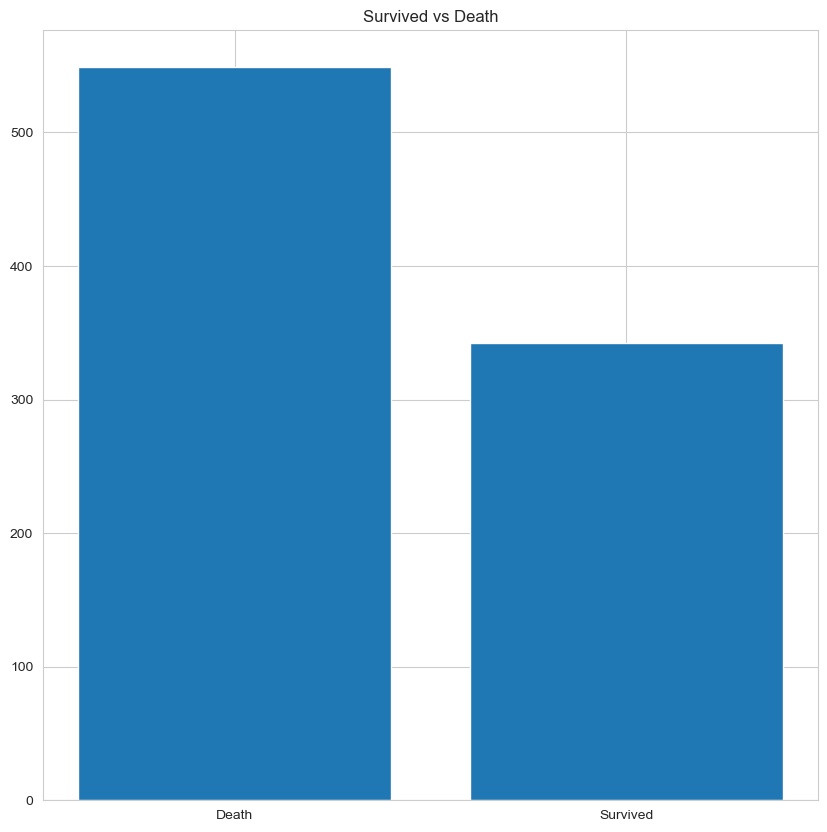

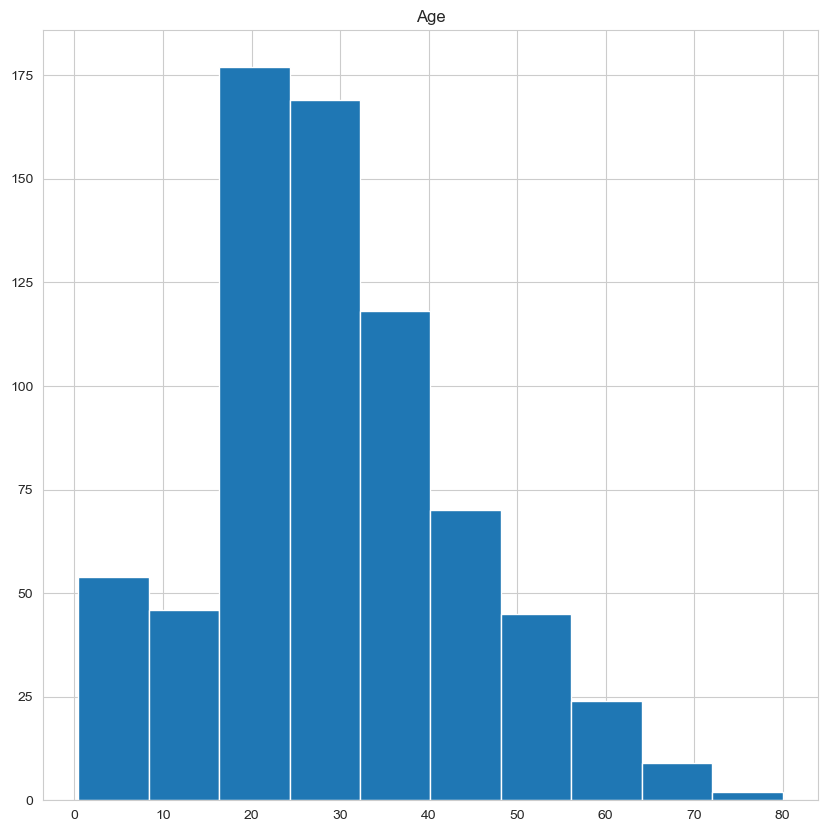

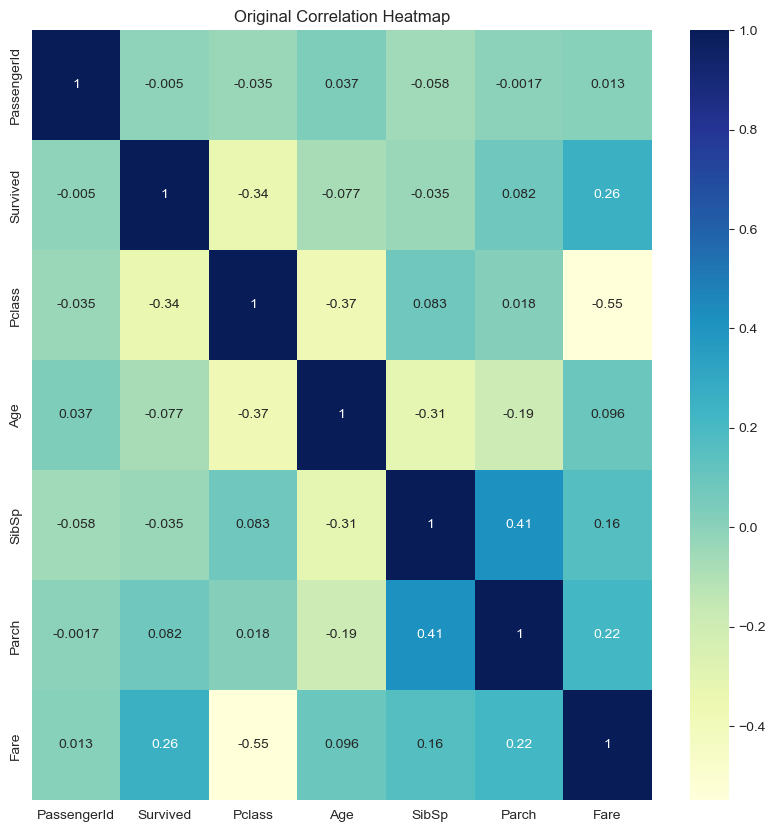

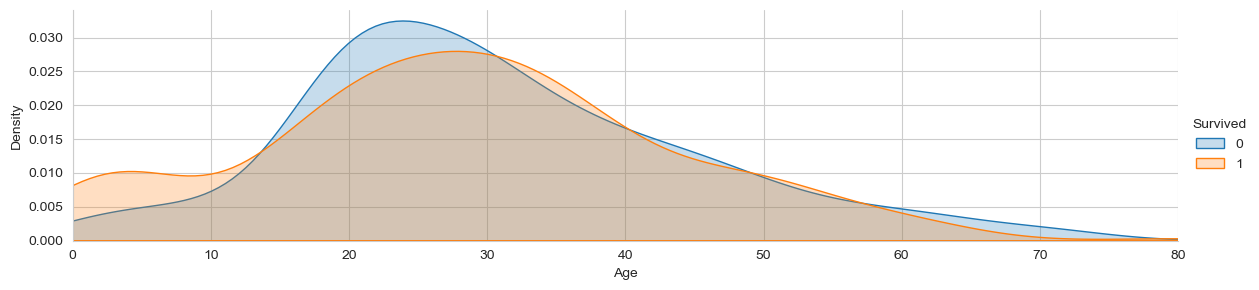

In [339]:
plt.figure(figsize=(10, 10))
plt.bar(["Death", "Survived"], df["Survived"].value_counts())
plt.title("Survived vs Death")
plt.show()

plt.figure(figsize=(10, 10))
plt.title("Age")
plt.hist(df["Age"].dropna())
plt.show()

plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="YlGnBu")
plt.title("Original Correlation Heatmap")
plt.show()

facet = sns.FacetGrid(df, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Age', fill=True)
facet.set(xlim=(0, df['Age'].max()))
facet.add_legend()
plt.show()


In [340]:
df['Embarked'].value_counts(dropna=False)

Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64

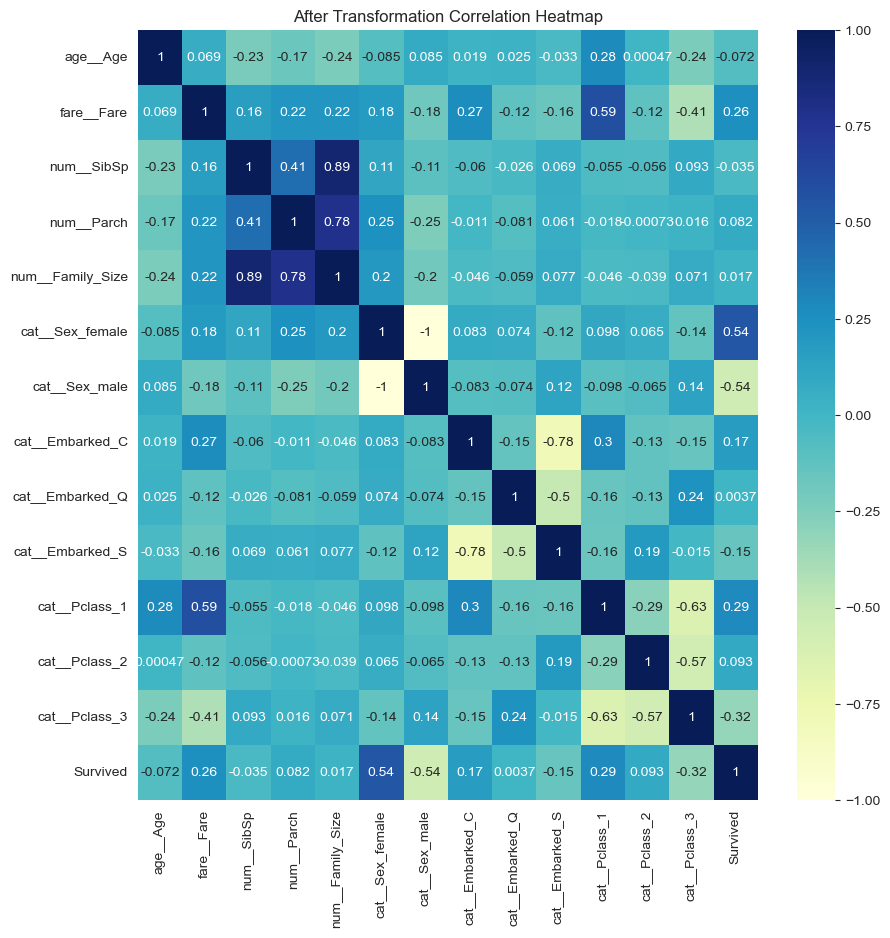

In [341]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

NUM_FEATURES = ['SibSp', 'Parch', 'Family_Size']
CAT_FEATURES = ['Sex', 'Embarked', 'Pclass']


class FamilySize(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        x_copy = X.copy()
        x_copy["Family_Size"] = x_copy["SibSp"] + x_copy["Parch"] + 1
        return x_copy

    def get_feature_names_out(self, input_features=None):
        return ['Family_Size']


class AgeBinner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.median_ = X['Age'].median()
        return self

    def transform(self, X):
        x_copy = X.copy()
        x_copy['Age'] = x_copy['Age'].fillna(self.median_)
        bins = [0, 16, 26, 36, 62, np.inf]
        labels = [0, 1, 2, 3, 4]
        x_copy['Age'] = pd.cut(x_copy['Age'], bins, labels=labels, include_lowest=True).astype(int)
        return x_copy[['Age']]

    def get_feature_names_out(self, input_features=None):
        return ['Age']


numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

age_pipeline = Pipeline(steps=[
    ('age_binner', AgeBinner())
])

fare_scaler = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('rscaler', RobustScaler()),
])

data_preprocessor = ColumnTransformer(transformers=[
    ('age', age_pipeline, ['Age']),
    ('fare', fare_scaler, ['Fare']),
    ('num', numerical_transformer, NUM_FEATURES),
    ('cat', categorical_transformer, CAT_FEATURES)
])

data_pipeline = Pipeline(steps=[
    ('family_size', FamilySize()),
    ('data_preprocessor', data_preprocessor),
])

df_clf = df.copy()
df_clf_test = df_test.copy()

data_pipeline.fit(df_clf)

X_train_transformed = data_pipeline.transform(df_clf)
X_test_transformed = data_pipeline.transform(df_clf_test)

column_names = data_pipeline.named_steps['data_preprocessor'].get_feature_names_out()

transformed_df = pd.DataFrame(X_train_transformed, columns=column_names)
transformed_df_test = pd.DataFrame(X_test_transformed, columns=column_names)

Y_dependent_variable = df['Survived']  # Variable dependiente, es decir, lo que quiero predecir

transformed_df["Survived"] = Y_dependent_variable
plt.figure(figsize=(10, 10))
sns.heatmap(transformed_df.corr(numeric_only=True), annot=True, cmap="YlGnBu")
plt.title("After Transformation Correlation Heatmap")
plt.show()

transformed_df.drop('Survived', axis=1, inplace=True)

In [342]:
# Split training and evaluation sets
X_train, X_val, y_train, y_val = train_test_split(transformed_df, Y_dependent_variable, test_size=0.2,
                                                  random_state=117, stratify=Y_dependent_variable)

# Models to be used
logistic_regression = LogisticRegression(max_iter=MAX_ITERATIONS)
decision_tree = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=117,
)

cross_validation_scores = cross_val_score(decision_tree, X_train, y_train, cv=5)
print("Mean Accuracy in cross validation:", cross_validation_scores)
# support_vector_classification_model = SVC()  #SupportVectorClassification
# random_forest = RandomForestClassifier(n_estimators=MAX_ITERATIONS)

# linear_regression = LinearRegression()
# epsilon_support_vector_regression_model = SVR()  #EpsilonSupportVectorRegressionModel

#Train the models
logistic_regression.fit(X_train, y_train)
decision_tree.fit(X_train, y_train)


Mean Accuracy in cross validation: [0.85314685 0.76223776 0.8028169  0.77464789 0.85915493]


DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                       random_state=117)

In [343]:
## Evaluación del modelo
y_logistic_regression_prediction = logistic_regression.predict(X_val)
y_decision_tree_prediction = decision_tree.predict(X_val)

print("*.*." * 20)
print("Logistic Regression:")
print("Score: \n", logistic_regression.score(X_train, y_train))
print("Confusion Matrix: \n", confusion_matrix(y_val, y_logistic_regression_prediction))
print("Classification Report: \n", classification_report(y_val, y_logistic_regression_prediction))
print("*.*." * 20)

print("*.*." * 20)
print("Decision Tree:")
print("Score: \n", decision_tree.score(X_train, y_train))
print("Confusion Matrix: \n", confusion_matrix(y_val, y_decision_tree_prediction))
print("Classification Report: \n", classification_report(y_val, y_decision_tree_prediction))
print("*.*." * 20)


*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.
Logistic Regression:
Score: 
 0.824438202247191
Confusion Matrix: 
 [[91 19]
 [22 47]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.83      0.82       110
           1       0.71      0.68      0.70        69

    accuracy                           0.77       179
   macro avg       0.76      0.75      0.76       179
weighted avg       0.77      0.77      0.77       179

*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.
*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.
Decision Tree:
Score: 
 0.8567415730337079
Confusion Matrix: 
 [[93 17]
 [22 47]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.85      0.83       110
           1       0.73      0.68      0.71        69

    accuracy                           0.78    

In [347]:
y_pred = logistic_regression.predict(transformed_df_test)

In [348]:
results = pd.DataFrame.from_dict({"PassengerId": df_test["PassengerId"], "Survived": y_pred})

In [349]:
results.to_csv("results.csv", index=False)